### Links:
* http://www.danvk.org/2015/01/07/finding-blocks-of-text-in-an-image-using-python-opencv-and-numpy.html
* http://felix.abecassis.me/2011/10/opencv-rotation-deskewing/

In [1]:
import sys; sys.path.append('scripts/')

In [2]:
from doc2text import *
from helpers import *
from curriedCv import *

In [3]:
from scipy.spatial.distance import euclidean
from matplotlib import pyplot as plt
from pylab import rcParams
%matplotlib inline

rcParams['figure.figsize'] = 20, 15 

---

# Black and white without shadow

In [4]:
def plot_letter_line_finding(image, plot=True):
    x = image.copy().astype(np.int32)
    x -= 1
    x[x > 0] = 0
    x = np.abs(x)
    bars = pd.Series(np.sum(x, axis=1))
    bars[bars < bars.mean()] = -1
    bars[bars > 0] = 1
    cb = np.cumsum(bars)
    if plot:
        cb.plot();
    return cb

In [5]:
def nice_black(image):
    return pipe(image, descew, dog, negate, normalize, gaussian, 
                level(black=0.0, white=1, gamma=1), float_to_uint8, to_gray, threshold)

In [6]:
img = load('data/1.jpg')
result = nice_black(img)
f = plot_letter_line_finding(result, plot=False)

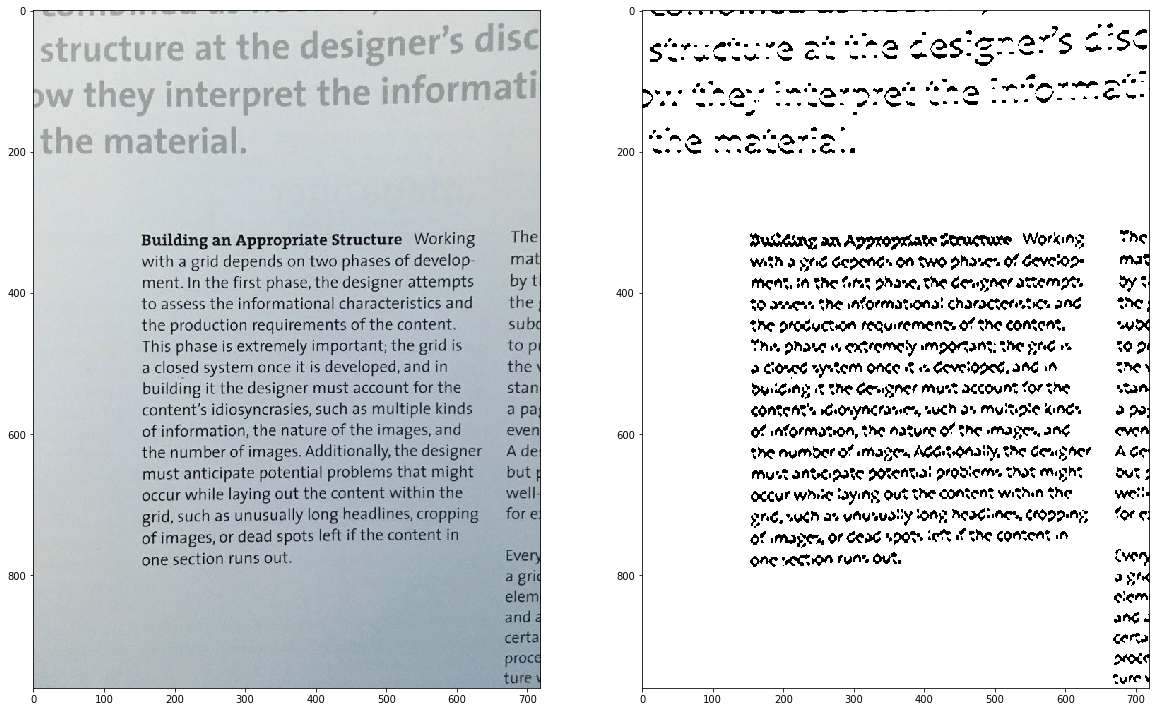

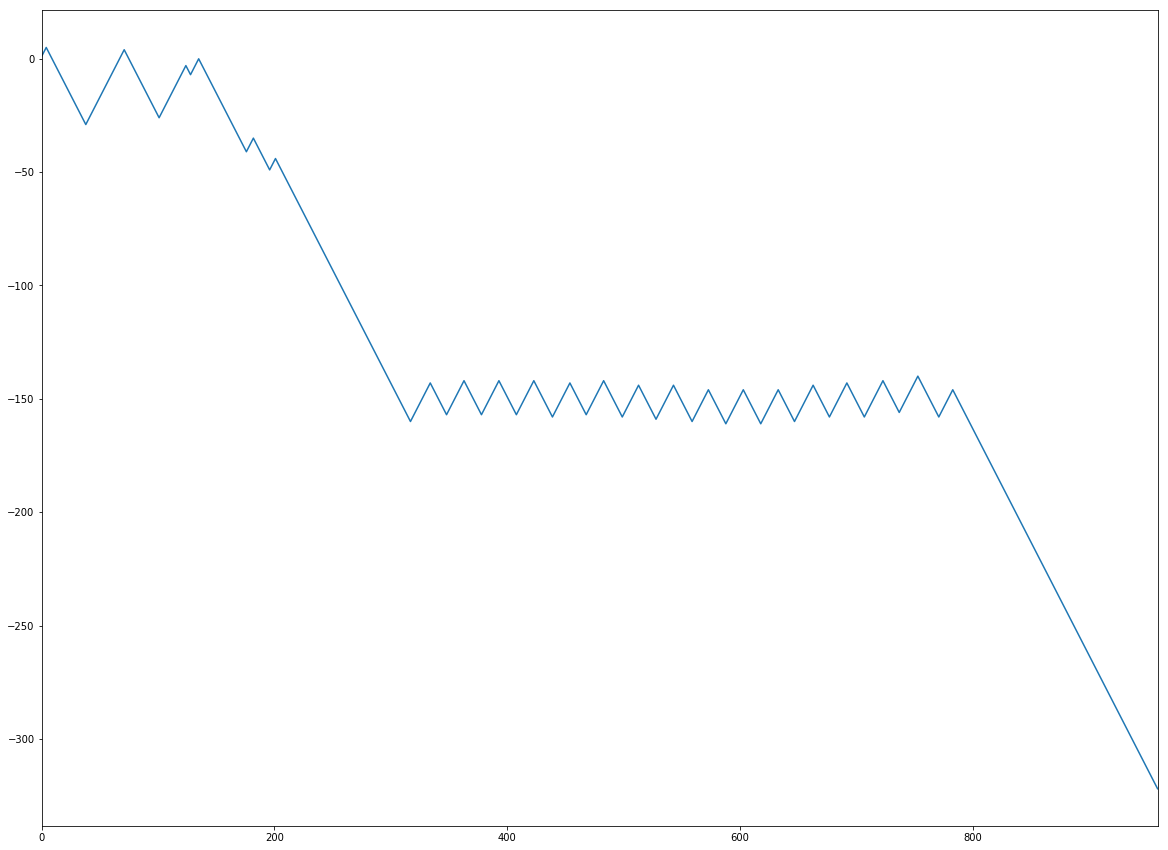

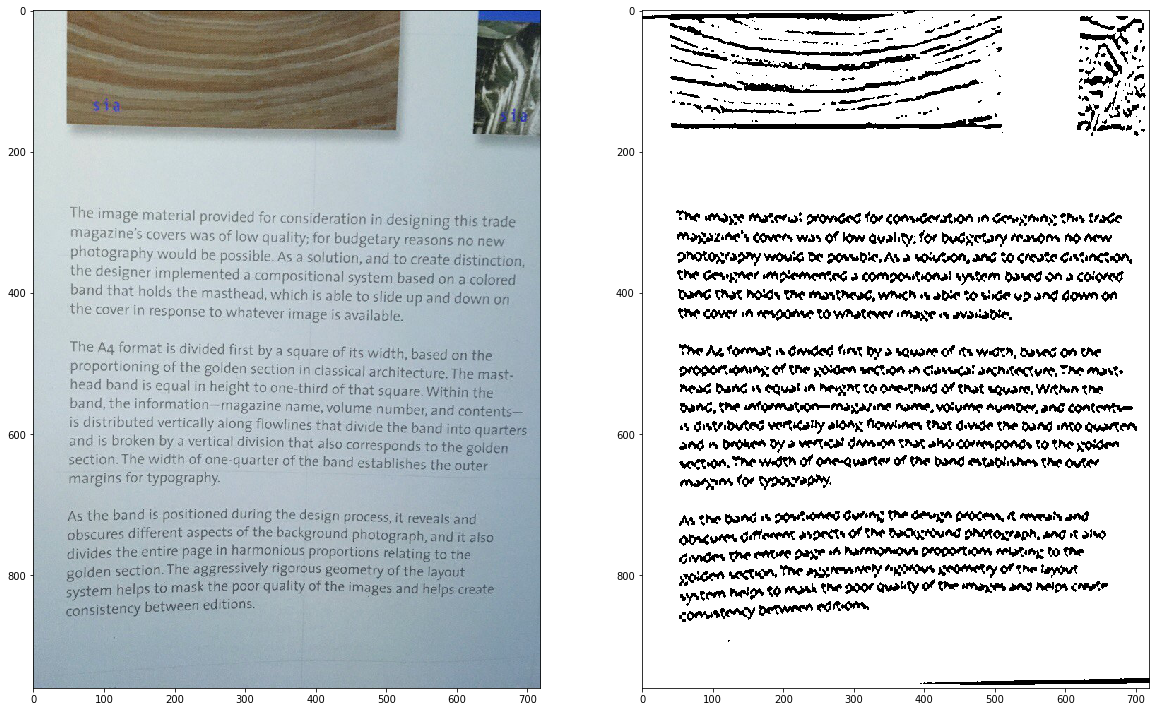

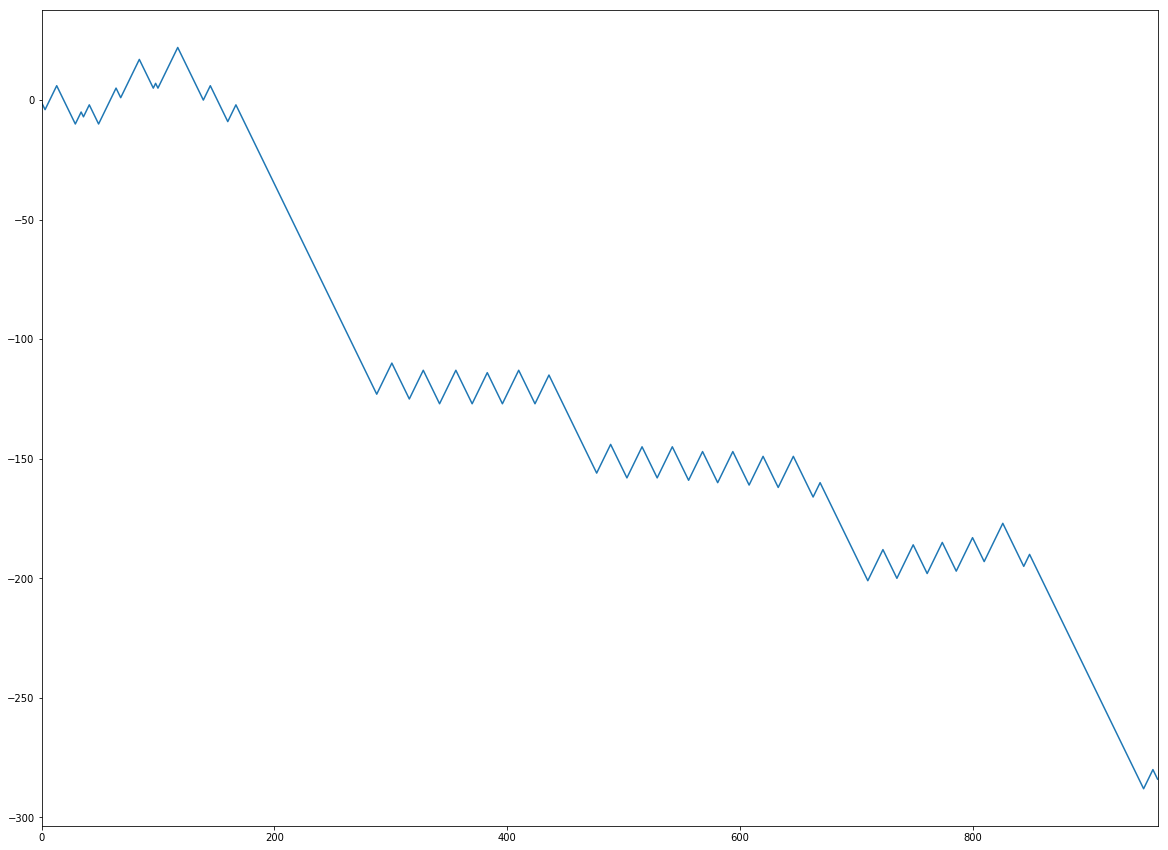

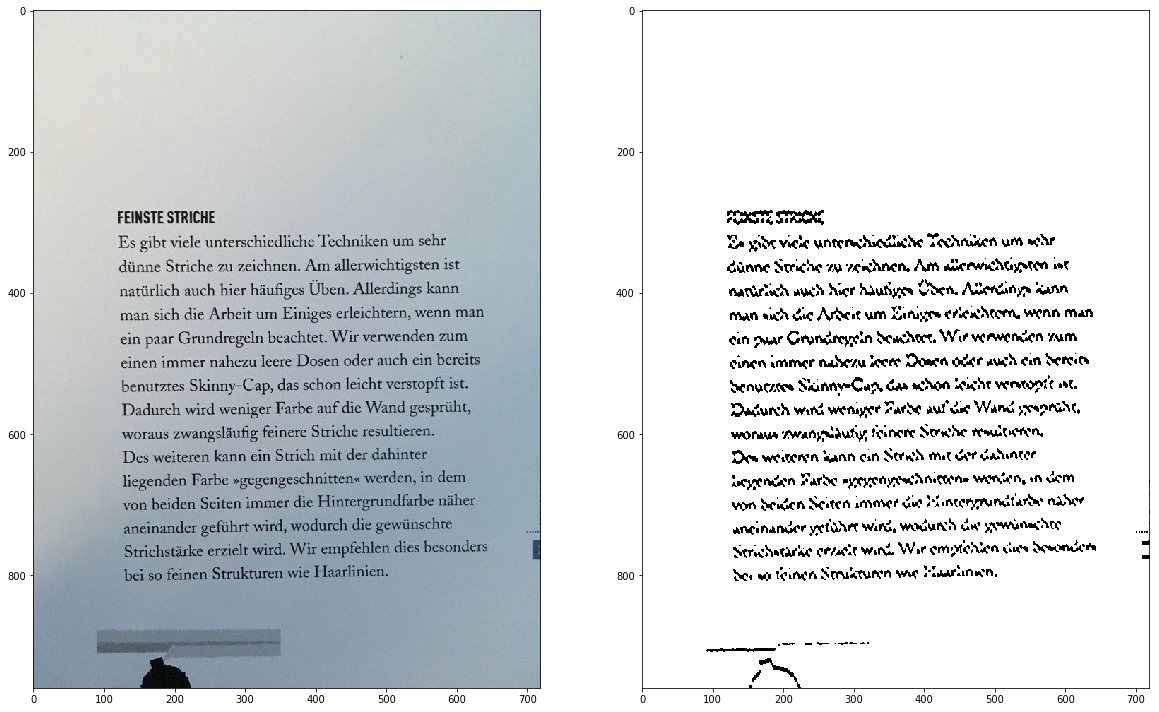

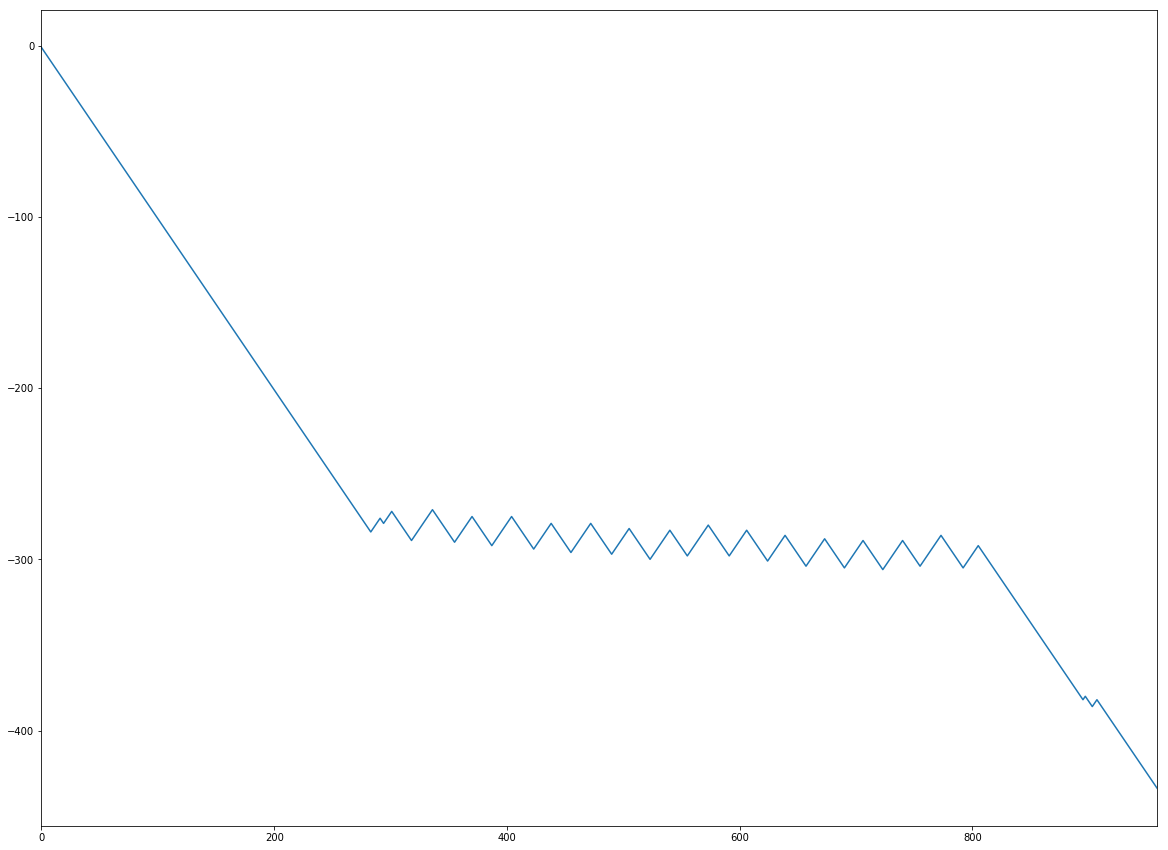

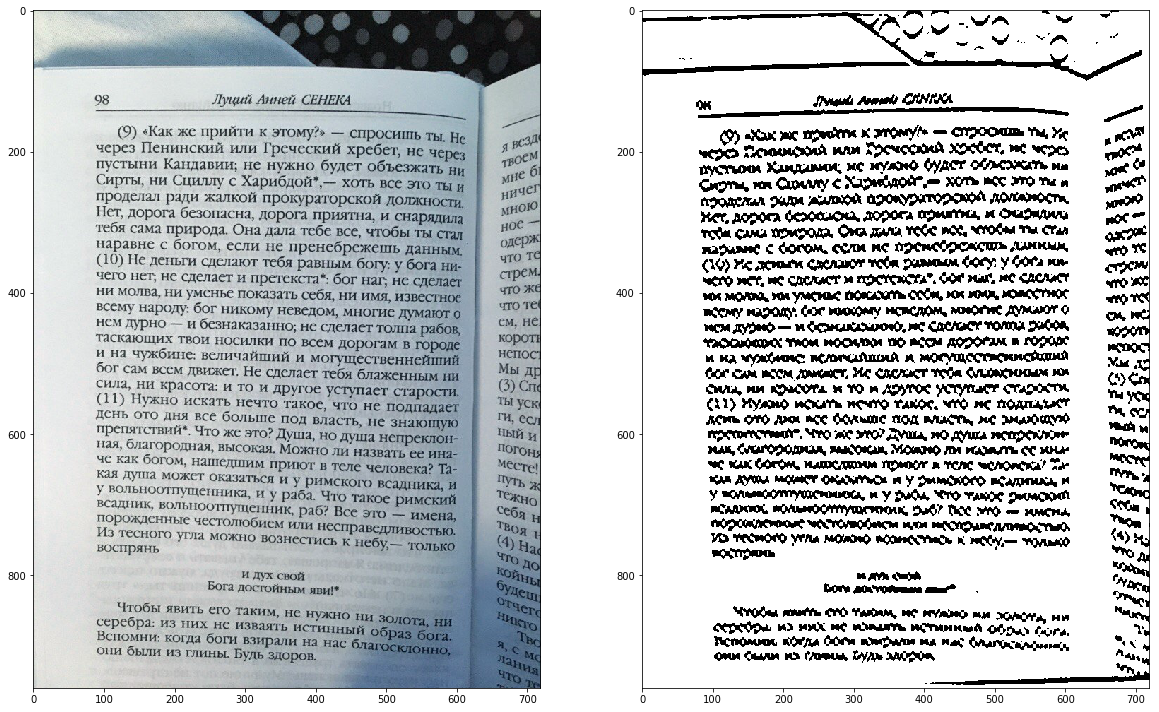

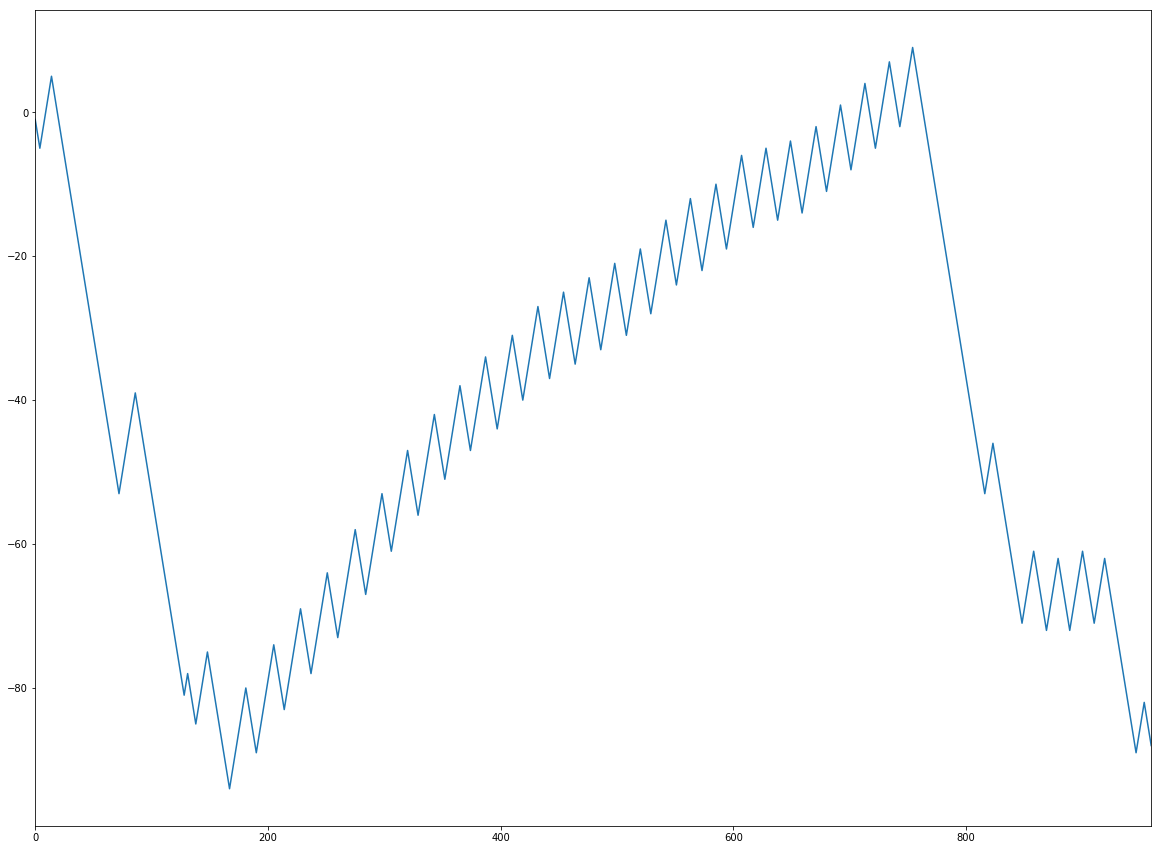

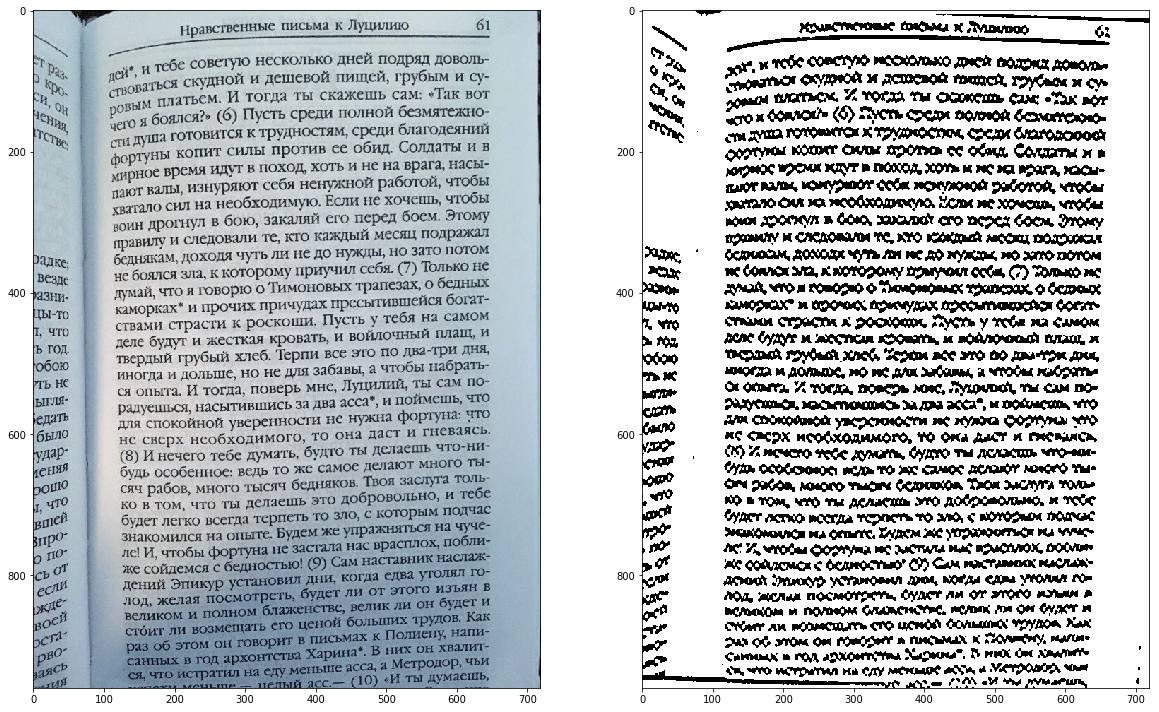

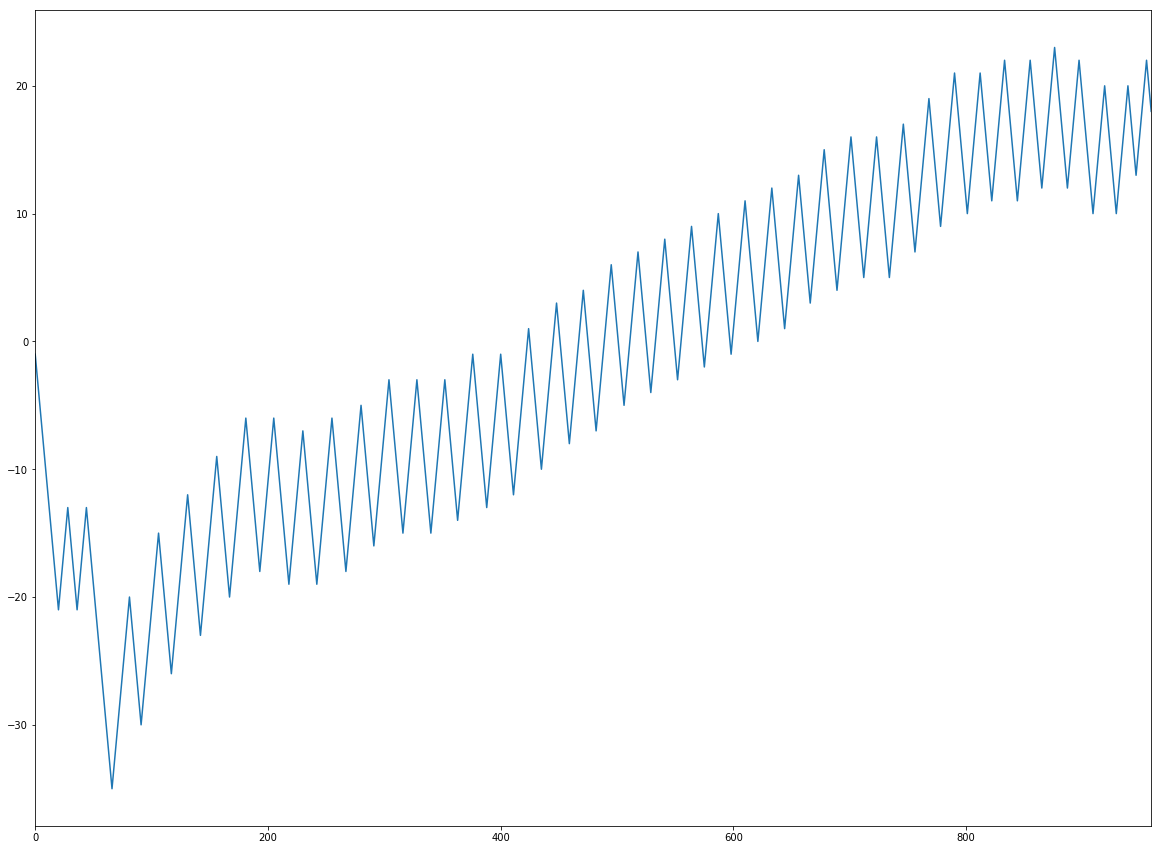

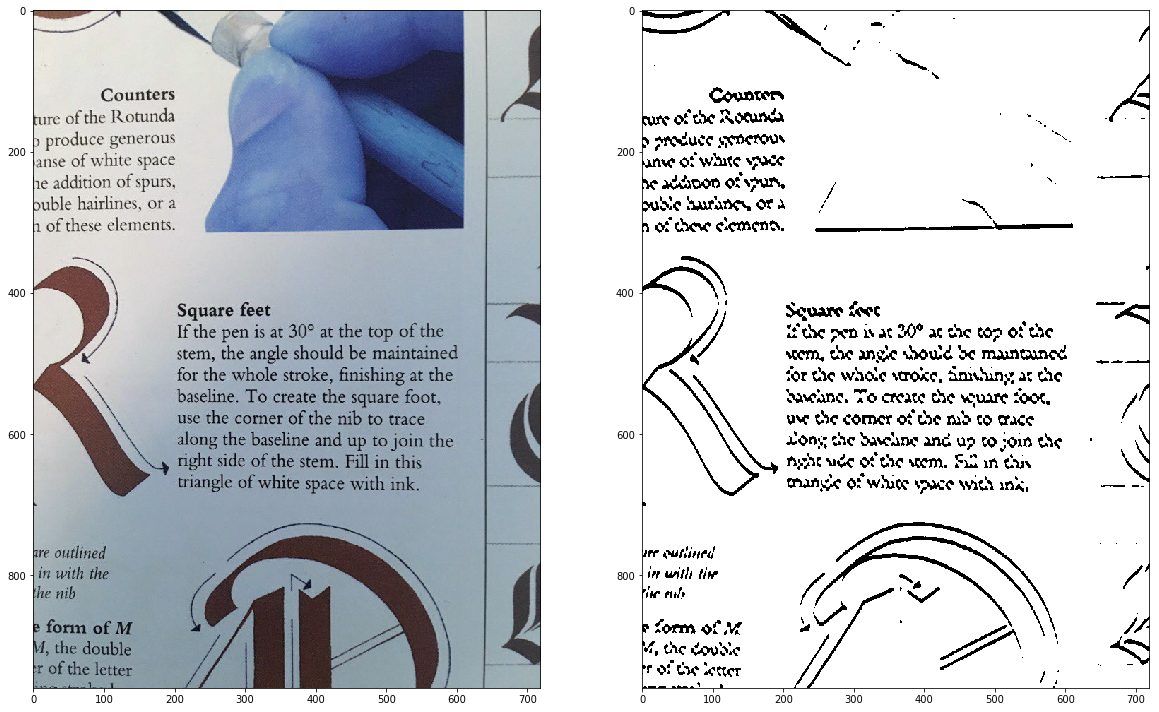

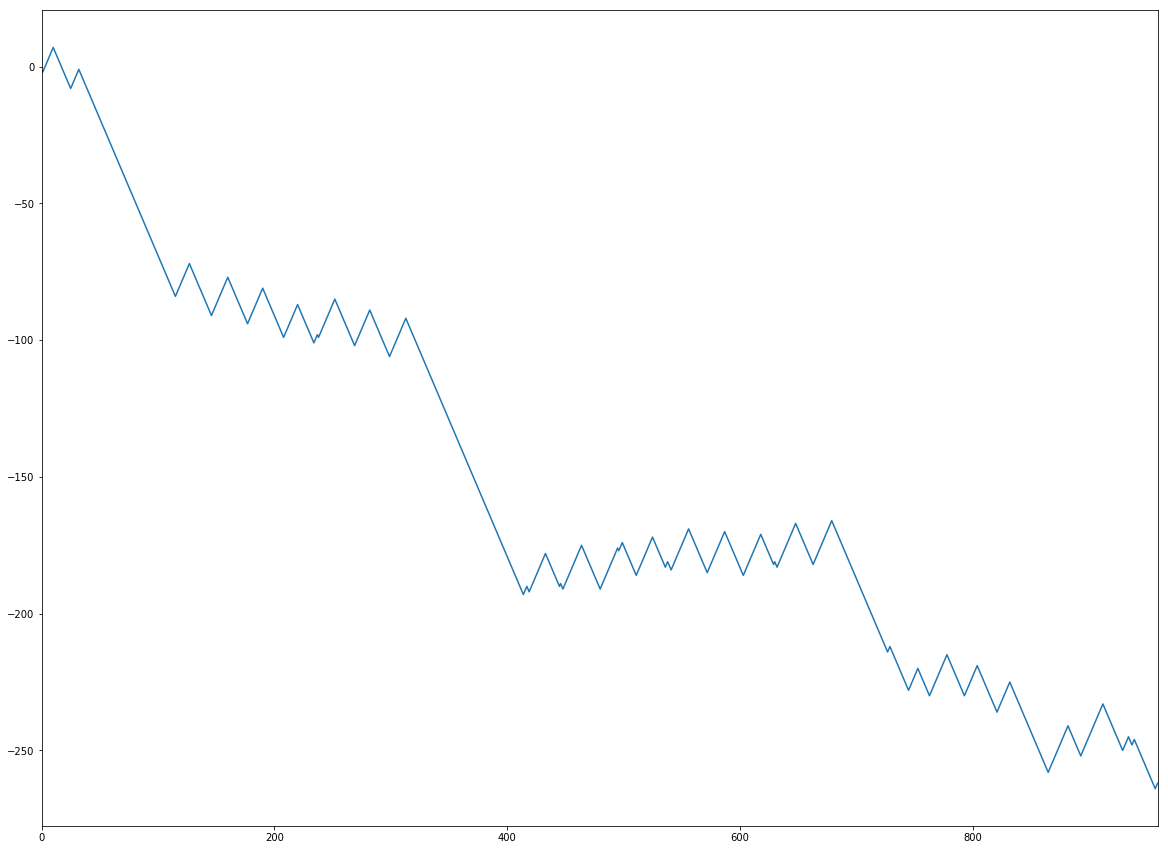

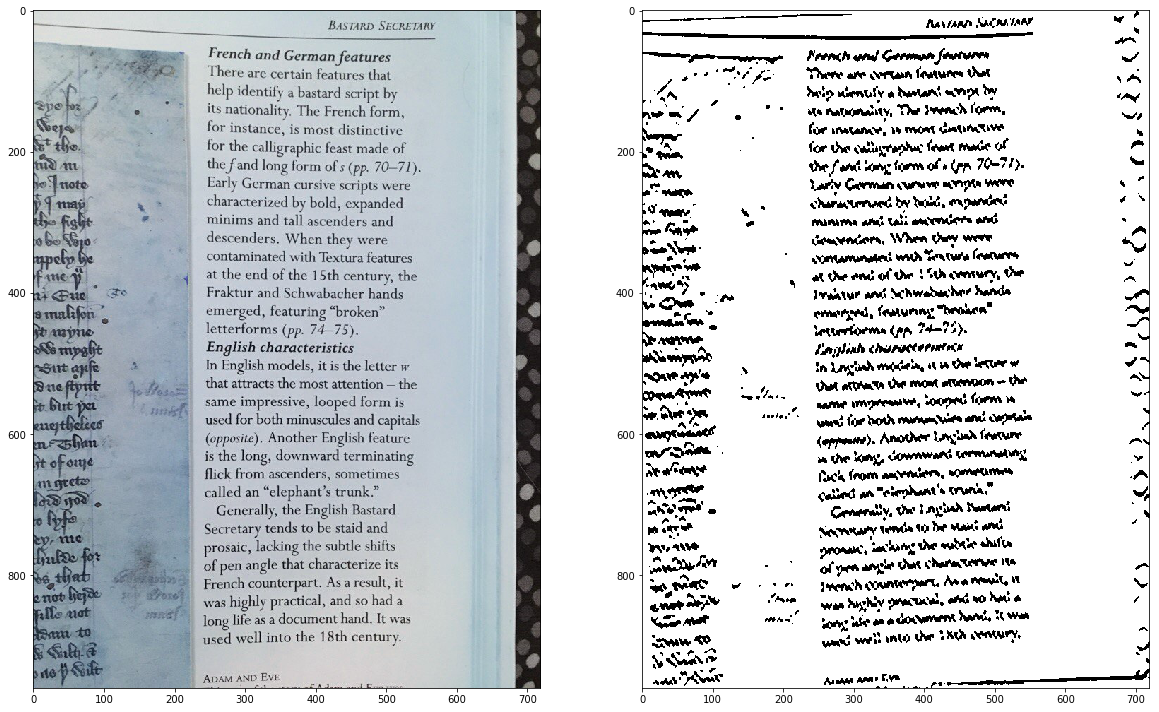

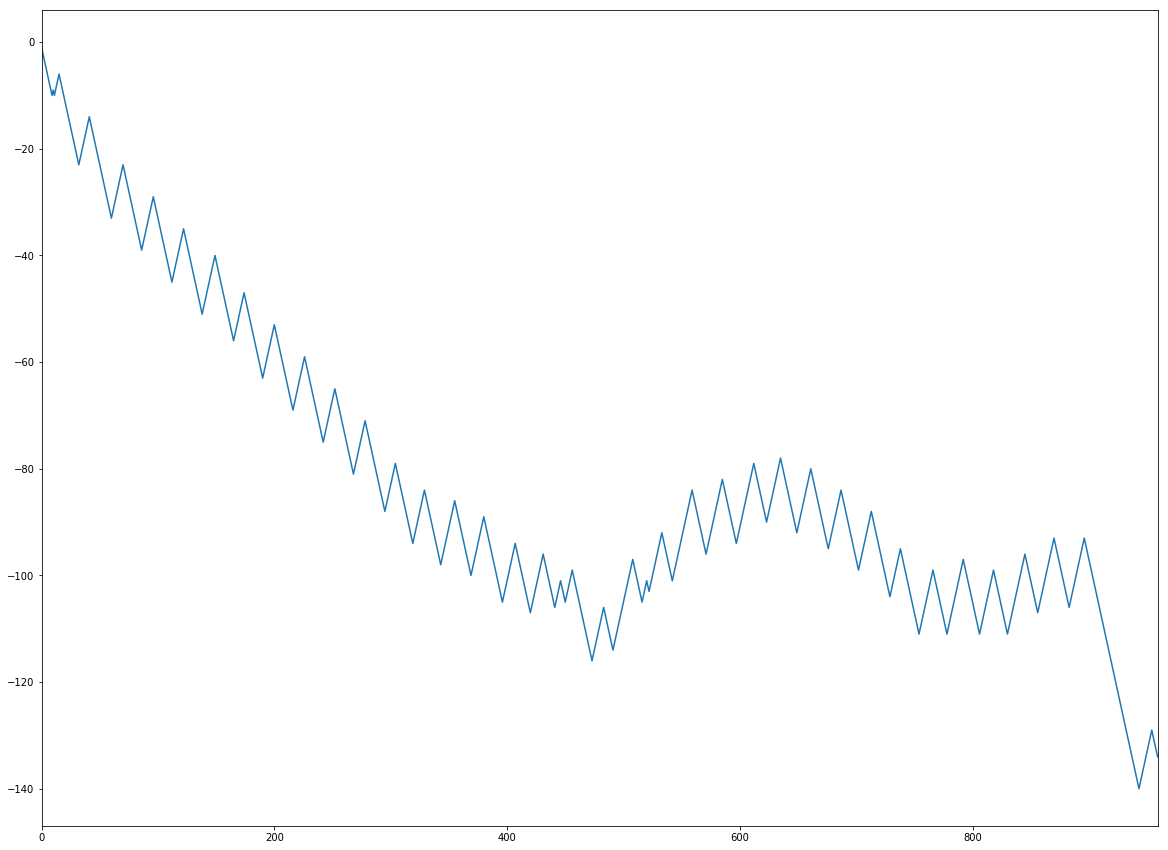

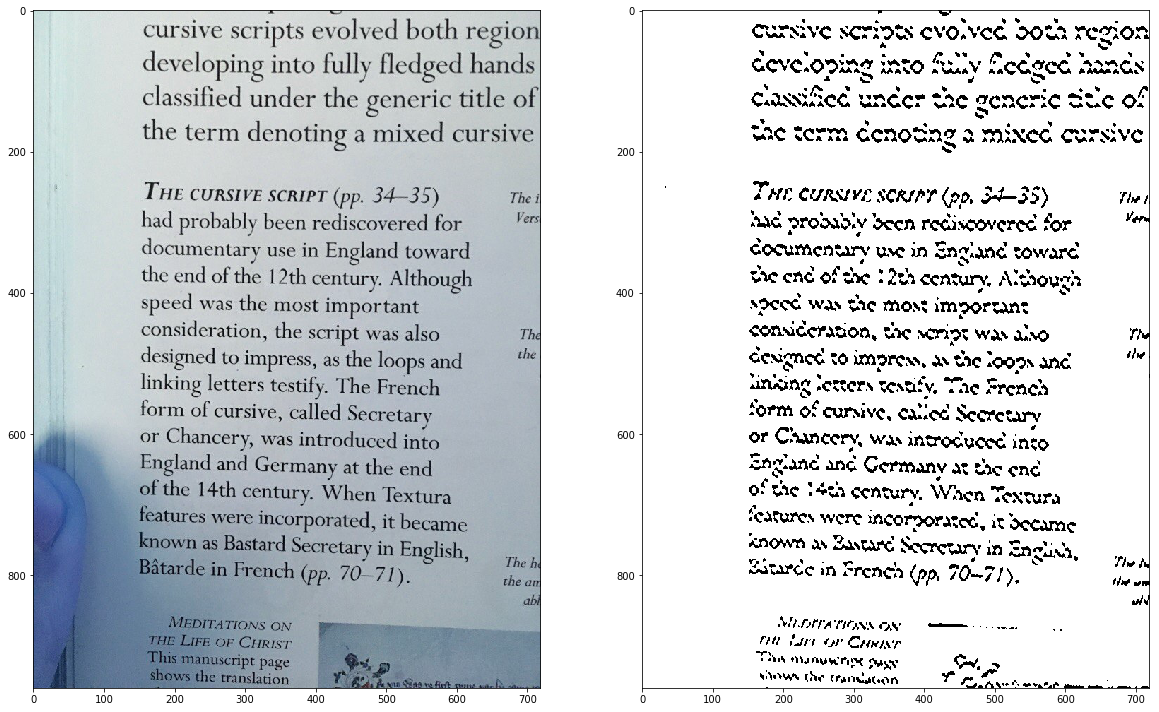

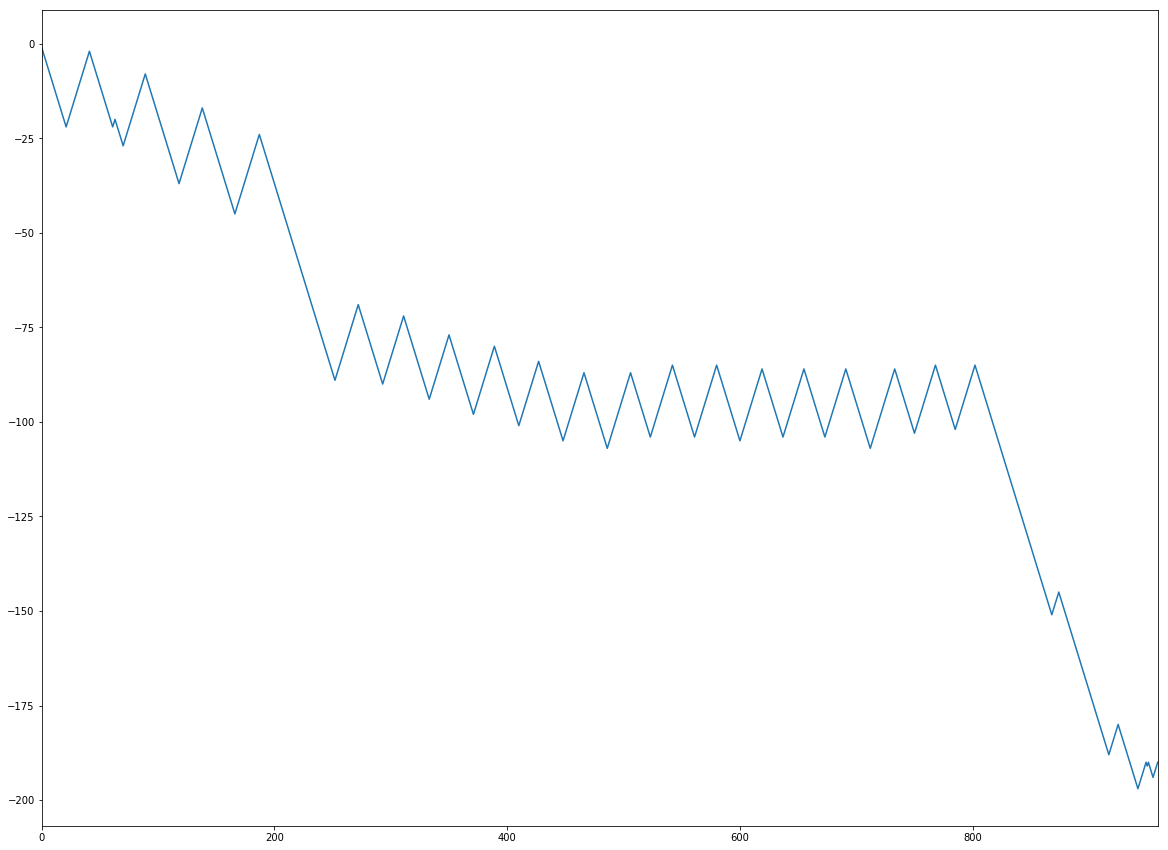

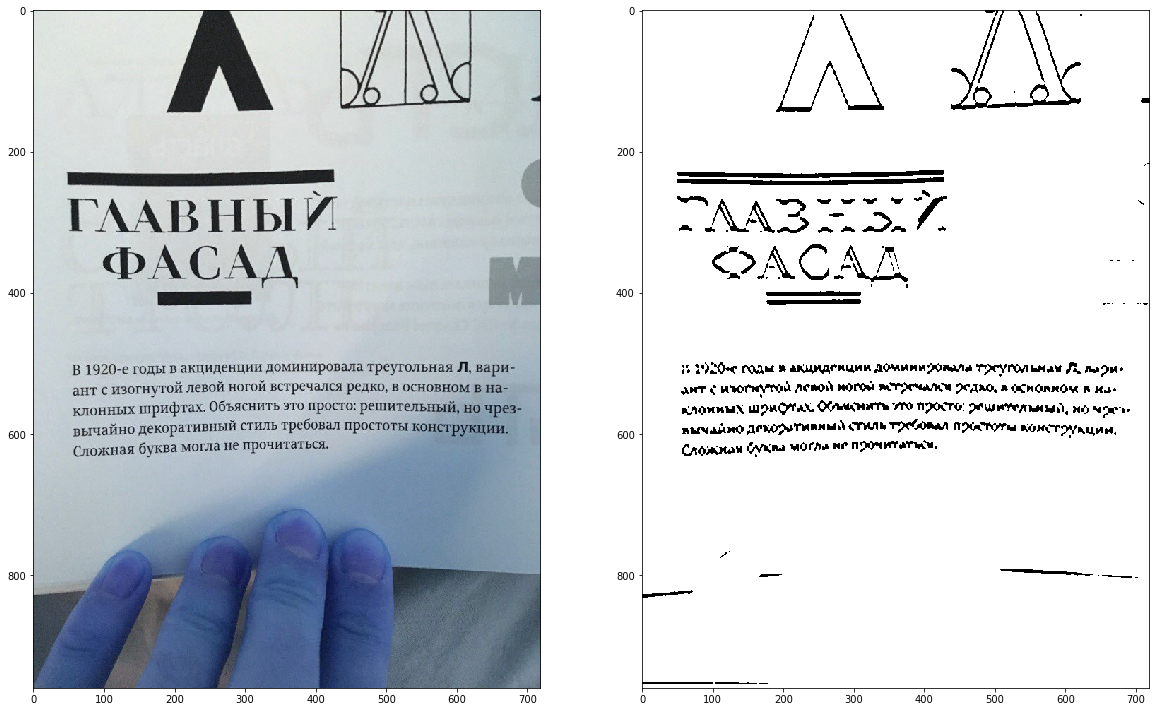

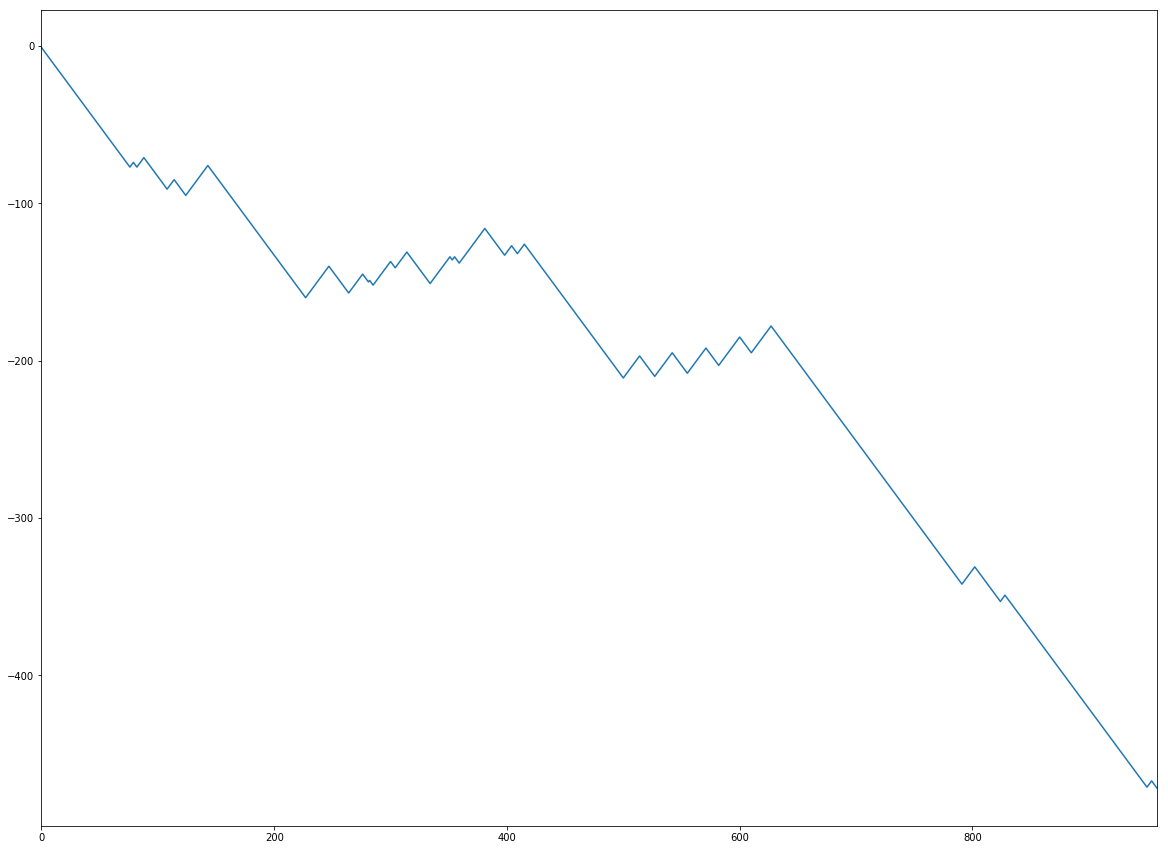

In [10]:
def my_pipe(path):
    img = load(path)
    result = nice_black(img)
    show(img, result)
    return plot_letter_line_finding(result)

[my_pipe('data/{}.jpg'.format(x)) for x in range(1,10)];

# Line height and cropping

In [7]:
from scipy.signal import argrelextrema

In [8]:
f = np.array(f)

In [9]:
px = argrelextrema(f, np.greater)[0]
cx = argrelextrema(f, np.less)[0]

In [10]:
peaks = [f[x] for x in px]
cavities = [f[x] for x in cx]

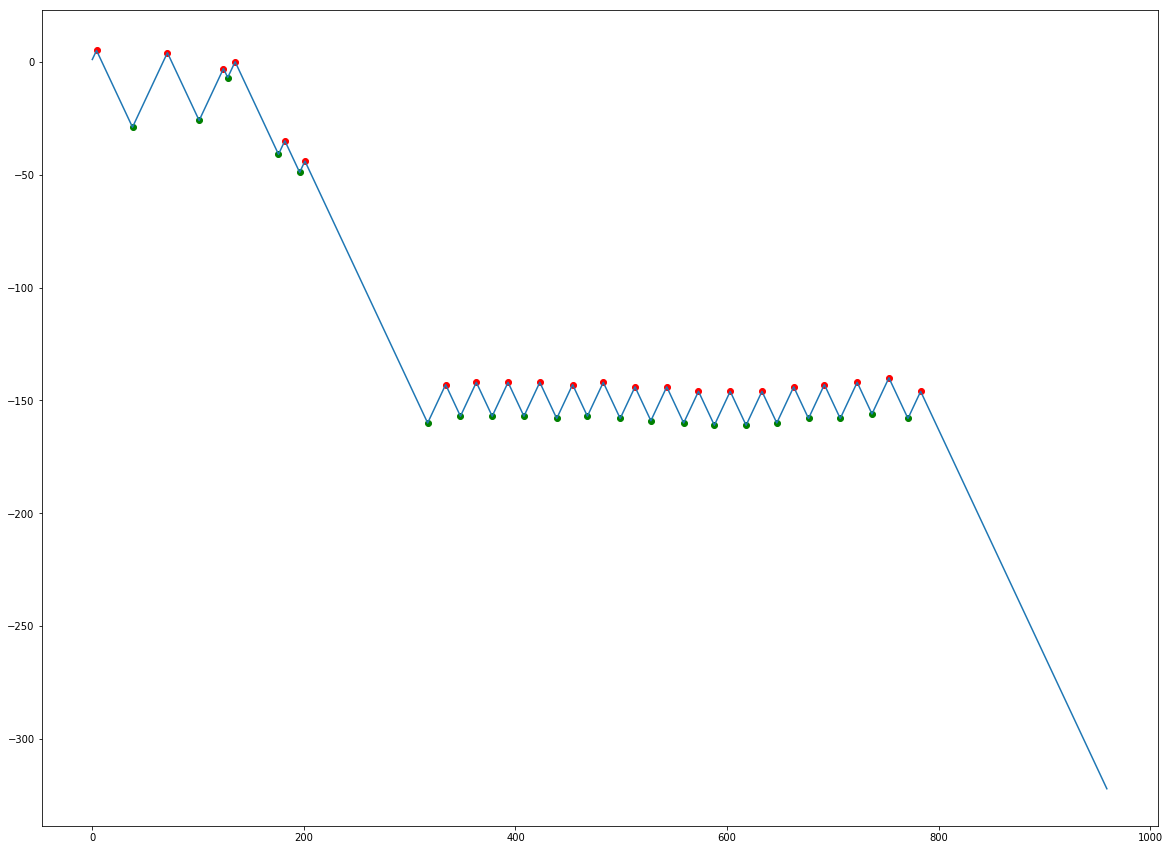

In [11]:
plt.figure()
plt.plot(f);
plt.scatter(px, peaks, c='r');
plt.scatter(cx, cavities, c='g');

In [12]:
dpeaks = [b-a for a,b in zip(px, px[1:])]
dcavs  = [b-a for a,b in zip(cx, cx[1:])]
dxx    = [b-a for a,b in zip(px, cx)]

In [13]:
np.percentile(dcavs, 20), np.median(dcavs), np.percentile(dcavs, 80)

(29.0, 30.0, 31.600000000000005)

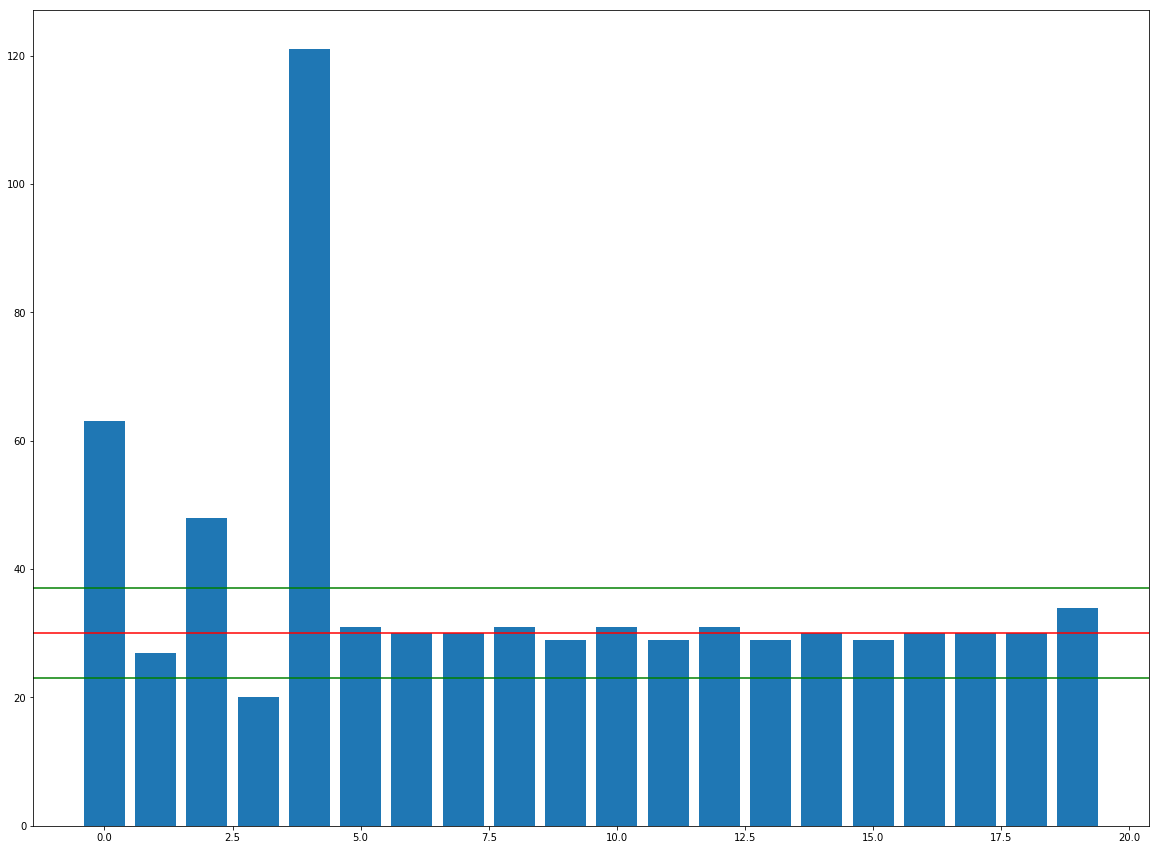

In [14]:
plt.figure()
plt.bar(range(len(dcavs)), dcavs);
plt.axhline(y=np.median(dcavs), color='r');
plt.axhline(y=np.median(dcavs) + np.std(dcavs)/3.0, color='g');
plt.axhline(y=np.median(dcavs) - np.std(dcavs)/3.0, color='g');

In [15]:
lower, upper = np.median(dcavs) - np.std(dcavs)/3.0, np.median(dcavs) + np.std(dcavs)/3.0
beginnings = [x[0] for x in zip(cx, dcavs) if upper >= x[1] >= lower]
line_height = int(np.median(dcavs) * 1.2)
shift = int(np.median(dcavs) * 0.2)

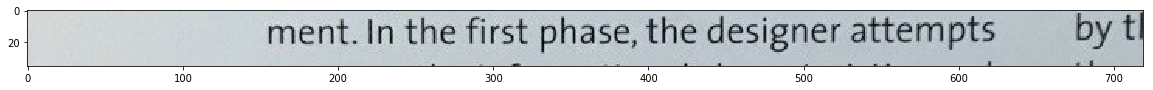

In [20]:
e = beginnings[3]
crop = img[e-shift:e-shift+line_height, 0:img.shape[1]]
show(crop)

# Blocks of text from community

http://stackoverflow.com/a/23672571/4116631

## Blocks with text

In [21]:
def black_white_from_pyrd(image_pyrd):
    gr = to_gray(image_pyrd)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3))
    grad = cv2.morphologyEx(gr, cv2.MORPH_GRADIENT, kernel)
    return threshold(grad)    

In [22]:
def rects_from_black_white(bw):
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (9,1))
    connected = cv2.morphologyEx(bw, cv2.MORPH_CLOSE, h_kernel)
    _, contours, _ = cv2.findContours(connected, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)
    return [cv2.boundingRect(x) for x in contours]

## Filtering rectangles

In [23]:
def rects_intersect(r1, r2, alpha=5):
    X1,Y1,W1,H1 = r1
    X2,Y2,W2,H2 = r2
    r = (r1[0] - alpha, r1[1] - alpha, r1[2] + 2*alpha, r1[3] + 2*alpha)
    X,Y,W,H = r
    one = not (X1+W1<X2 or X2+W2<X1 or Y1+H1<Y2 or Y2+H2<Y1)
    two = not (X +W <X2 or X2+W2<X  or Y +H <Y2 or Y2+H2<Y )
    return one or two

def cluster_contains(rect, cluster):
    for another in cluster:
        if rects_intersect(rect, another):
            return True
    return False

def cluster_rects(rects):
    clusters = []
    for r in rects:
        if len(clusters) == 0:
            clusters.append([r])
        else:
            added = False
            for c in clusters:
                if cluster_contains(r, c):
                    c.append(r)
                    added = True
            if not added:
                clusters.append([r])
    return clusters

def bound(cluster):
    x_min = min([rect[0]         for rect in cluster])
    y_min = min([rect[1]         for rect in cluster])
    x_max = max([rect[0]+rect[2] for rect in cluster])
    y_max = max([rect[1]+rect[3] for rect in cluster])
    return (x_min, y_min, x_max-x_min, y_max-y_min)

def process_rects(rects, s_threshold=0.1):
    clusters = cluster_rects(rects)
    bounding_rects_old = list(set([bound(c) for c in clusters]))
    bounding_rects = [x for x in bounding_rects_old if x[2]*x[3]/(pyrd.shape[0]*pyrd.shape[1]) >= s_threshold]
    return process_rects(bounding_rects) if len(bounding_rects) != len(bounding_rects_old) else bounding_rects

In [24]:
def whiteness_in(image):
    return cv2.countNonZero(image) / np.multiply(*image.shape)

In [25]:
def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

In [26]:
def _get_min_max(f, comparator):
    xs = argrelextrema(f, comparator)[0]
    if len(xs) == 0:
        return []
    return [(x, f[x]) for x in xs] 

def get_minima(f):
    return _get_min_max(f, np.less)

def get_maxima(f):
    return _get_min_max(f, np.greater)

In [27]:
def get_crop_goodness(crop):
    smoothed = moving_average(np.sum(crop, axis=1), n=10)
    return sum([a[1]-b[1] for a,b in zip(get_maxima(smoothed), get_minima(smoothed))])

---

(76, 156, 243, 239) 	 0.453690789814 	 388926.0
(0, 0, 360, 76) 	 0.176644736842 	 64132.5


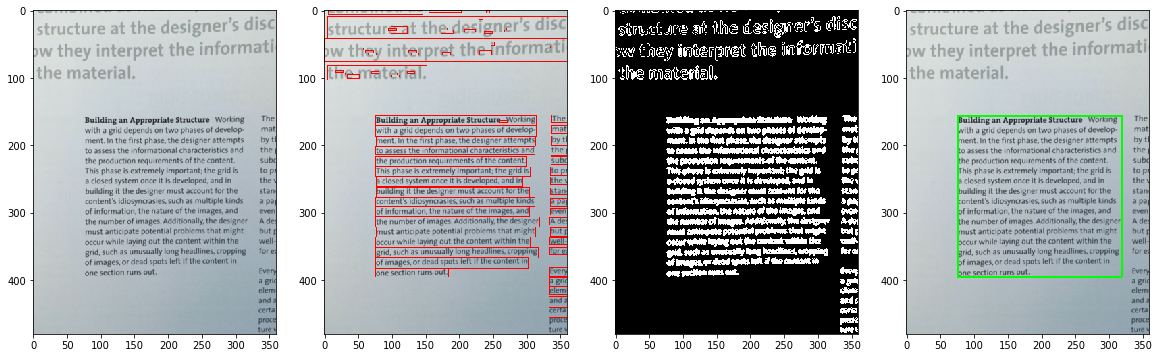

In [29]:
img = load('data/1.jpg')
pyrd = cv2.pyrDown(img)

bw = black_white_from_pyrd(pyrd)
rects = rects_from_black_white(bw)
final_regions = process_rects(rects)

canvas_rects    = pyrd.copy()
canvas_clusters = pyrd.copy()
canvas_final    = pyrd.copy()

r = lambda: (np.random.randint(255), np.random.randint(255), np.random.randint(255))
colors = [r() for _ in range(100)]

for r in rects:
    cv2.rectangle(canvas_rects, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), (255,0,0), 1)

for i, r in enumerate(final_regions):
    cv2.rectangle(canvas_clusters, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), colors[i], 2)

goodnesses = []
for x in final_regions:
    crop = bw[x[1]:x[1]+x[3], x[0]:x[0]+x[2]]
    g = get_crop_goodness(crop)
    print(x, '\t', whiteness_in(crop), '\t', g)
    goodnesses.append(g)

K = 3

best = max(goodnesses)
ok = []
for reg, gdn in zip(final_regions, goodnesses):
    if best/gdn < K:
        ok.append(reg)

enlarge = lambda r: (r[0]*2, r[1]*2, r[2]*2, r[3]*2)
for r in ok:
    crop = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]

for r in ok:
    cv2.rectangle(canvas_final, (r[0], r[1]), (r[0]+r[2], r[1]+r[3]), (0,255,0), 2)

show(pyrd, canvas_rects, bw, canvas_final)

---

In [30]:
def crop_stuff(number):
    inpath  = 'data/{}.jpg'.format(number)
    outpath = 'out/{}'.format(number)
    
    img = load(inpath)
    pyrd = cv2.pyrDown(img)

    bw = black_white_from_pyrd(pyrd)
    rects = rects_from_black_white(bw)
    final_regions = process_rects(rects)

    goodnesses = []
    for x in final_regions:
        crop = bw[x[1]:x[1]+x[3], x[0]:x[0]+x[2]]
        g = get_crop_goodness(crop)
        goodnesses.append(g)

    K = 3

    best = max(goodnesses)
    ok = []
    for reg, gdn in zip(final_regions, goodnesses):
        if best/gdn < K:
            ok.append(reg)

    enlarge = lambda r: (r[0]*2, r[1]*2, r[2]*2, r[3]*2)
    for i, w in enumerate(ok):
        r = enlarge(w)
        crop = img[r[1]:r[1]+r[3], r[0]:r[0]+r[2]]
        p = outpath + '_{}.jpg'
        cv2.imwrite(p.format(i), crop)

In [116]:
for i in range(1,10):
    crop_stuff(i)